# NeXus Data Format

NeXus is an international standard for storing neutron, x-ray and muon data. NeXus data are stored in HDF5 files, using a logical design that makes them easy to navigate, and a pre-defined dictionary of groups, fields, and attributes that describe commonly occurring experimental metadata. Further details can be found on the [NeXus website](http://www.nexusformat.org). This notebook provides a tutorial on using the Python [nexusformat package](http://nexpy.github.io/nexpy/pythonshell.html) to read, write, and manipulate NeXus data.

## Installation
Before running this notebook, you should make sure that the `nexusformat` package has been installed. If you have an Anaconda Python environment, type:

    >>> conda install -c nexpy nexusformat
    
Otherwise, type:

    >>> pip install nexusformat

> *N.B.* The `nexusformat` package uses [h5py](http://www.h5py.org) to read and write the underlying HDF5 files. It also requires [numpy](http://numpy.scipy.org/) and, if plotting is required, [matplotlib](http://www.matplotlib.org).

If already installed, you can skip the following cell:

In [1]:
!pip install nexusformat

Once installed, it can be imported using:

In [2]:
from nexusformat.nexus import *

> *N.B.* Wildcard imports are usually discouraged, but all the imported names have `NX` or `nx` as a prefix, reducing the risk of name clashes.

## NeXus Fields
NeXus data and metadata are stored as either numeric fields (scalar or array) or text strings. In the `nexusformat` package, fields can be created dynamically created from the command line, even if no NeXus file is open.

In [3]:
import numpy as np
x=NXfield(np.linspace(1,10.0,10))
x

NXfield(array([ 1.,  2.,  3., ...,  8.,  9., 10.]))

In this case, the `NXfield` object contains the Numpy array, and can be manipulated using standard Numpy operations.

In [4]:
x + 10

NXfield(array([11., 12., 13., ..., 18., 19., 20.]))

In [5]:
np.sin(x)

NXfield(array([ 0.84147098,  0.90929743,  0.14112001, ...,  0.98935825,
        0.41211849, -0.54402111]))

In [6]:
x+np.linspace(11,20.0,10)

NXfield(array([12., 14., 16., ..., 26., 28., 30.]))

Like Numpy arrays, NeXus fields have datatypes and shape, which can be manipulated using standard Numpy operations.

In [7]:
x.dtype

dtype('float64')

In [8]:
x.reshape((2,5))

NXfield(array([[ 1.,  2.,  3.,  4.,  5.],
       [ 6.,  7.,  8.,  9., 10.]]))

It is also possible to create large empty arrays and fill them incrementally as slabs. The array is stored in an in-memory HDF5 file until it is saved to disk. 

In [9]:
x=NXfield(shape=(1000,1000), dtype=np.float32, fillvalue=np.nan)
x[0,3:6]=range(3)
x[0,0:7]

NXfield(array([nan, nan, nan, ...,  1.,  2., nan], dtype=float32))

NeXus fields can contain scalars and arrays of any Numpy data type, as well as text, which is stored in NeXus files as variable-length strings, by default.

In [10]:
title=NXfield('Small-Angle Scattering')
title

NXfield('Small-Angle Scattering')

## NeXus Groups
NeXus fields are stored in groups, which have a class that defines the type of content it contains. In `nexusformat`, these are subclasses of the `NXgroup` class.

In [11]:
instrument=NXgroup(name='instrument', nxclass='NXinstrument')
instrument

NXinstrument('instrument')

For classes defined by the NeXus standard, the group can be instantiated by its class name. You can find a list of NeXus classes in the [online manual](http://download.nexusformat.org/doc/html/classes/base_classes/).

In [12]:
sample=NXsample()
sample

NXsample('sample')

Fields and groups can be added to any group, using either attribute (*i.e.*, `a.b=c`) or dictionary (*i.e.*, `a['b']=c`) assignments.

In [13]:
entry=NXentry()
entry.title=title
entry.sample=sample
entry['instrument']=instrument
print(entry.tree)

entry:NXentry
  instrument:NXinstrument
  sample:NXsample
  title = 'Small-Angle Scattering'


> *N.B.* Dictionary assignments are safer when there are potential name clashes with, *e.g.*, Numpy attributes, and should be used when writing scripts. However, attribute assignments are allowed as a convenience as they are quicker to type in interactive sessions.

Since group entries are defined in a dictionary, the usual dictionary operations are available.

In [14]:
'sample' in entry

True

In [15]:
for name in entry:
    if isinstance(entry[name], NXfield):
        print("'%s' is a field" % name)
    elif isinstance(entry[name], NXgroup):
        print("'%s' is a group" % name)

'title' is a field
'sample' is a group
'instrument' is a group


The attribute or dictionary name used in the group assignment overrides any internal name that might have been defined when creating the NeXus object.

In [16]:
temperature=NXfield(40.0, name='temp')
entry.sample.temperature=temperature
print(entry.sample.tree)

sample:NXsample
  temperature = 40.0


Extended path strings are recognized in dictionary assignments.

In [17]:
entry['sample/mass']=10.0
print(entry.tree)

entry:NXentry
  instrument:NXinstrument
  sample:NXsample
    mass = 10.0
    temperature = 40.0
  title = 'Small-Angle Scattering'


## Attributes
Both groups and fields can have attributes that provide additional metadata or serve a structural purpose, such as identifying axes. These are stored in the `attrs` dictionary.

In [18]:
entry.sample.temperature.attrs['units']='K'
print(sample.tree)

sample:NXsample


In the case of NXfields, attributes can be defined using keyword arguments to the NXfield.

In [19]:
mass=NXfield(10.0,units='g')

## NXData Groups
The NeXus format defines groups, with class `NXdata`, which are designed to contain the results of the experimental measurement and make them easy to plot. To accomplish this, these groups contain a field, containing one-dimensional or multidimensional arrays, that is designated as the **signal** and one or more one-dimensional fields that are designated as the **axes**. 
### Creating NXdata Groups
The `nexusformat` API has a special constructor for creating `NXdata` groups, which allows the signal and axes to be specified as the first two positional arguments.

In [20]:
en=NXfield(np.linspace(10,35,26),name='energy_transfer',dtype=np.float32,units='meV',
          long_name='Energy Transfer (meV)')
co=NXfield([26,28,49,52,96,165,369,932,1933,3510,5170,6265,6863,6766,5566,4366,2789,1611,928,635,392,266,169,141,113,73],
           name='counts',dtype=np.int16,long_name='Detector Counts')
data1D=NXdata(co, [en], title='Example 1D Data')
print(data1D.tree)

data:NXdata
  @axes = 'energy_transfer'
  @signal = 'counts'
  counts = int16(26)
    @long_name = 'Detector Counts'
  energy_transfer = float32(26)
    @long_name = 'Energy Transfer (meV)'
    @units = 'meV'
  title = 'Example 1D Data'


In this example, the first two arguments contain fields representing the signal and axes, respectively. 
> *N.B.* In the case of one-dimensional data, it is not necessary to specify the axes as a list.

> *N.B.* We used the keyword argument, `name`, when creating the NXfields. This is the name is used for the field within the NXdata group. Otherwise, default names would have been assigned to the fields, such as `signal`, `axis1`, `axis2`, *etc.*

If you want to use group assignments to generate the name automatically, you can create an empty NXdata group and define its `nxsignal` and `nxaxes` properties.

In [21]:
data2D=NXdata()
data2D.xvals=data2D.yvals=np.linspace(0,2.*np.pi,101)
X,Y=np.meshgrid(data2D.xvals,data2D.yvals)
data2D.zvals=np.sin(X)*np.sin(Y)
data2D.nxsignal=data2D.zvals
data2D.nxaxes=[data2D.yvals,data2D.xvals]
data2D.title='Example 2D Data'
print(data2D.tree)

data:NXdata
  @axes = ['yvals', 'xvals']
  @signal = 'zvals'
  title = 'Example 2D Data'
  xvals = float64(101)
  yvals = float64(101)
  zvals = float64(101x101)


In this example, the `signal` and `axes` attributes of the `NXdata` group were automatically set when the `nxsignal` and `nxaxes` properties were specified.
### Plotting NXdata Groups
The information within the NXdata group is sufficient to allow them to be plotted automatically.

In [22]:
data1D.plot()
data2D.plot()

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 2 Axes>

The `nexusformat` package uses Matplotlib for plotting. The first positional argument of the `plot` function can contain a Matplotlib formatting string.

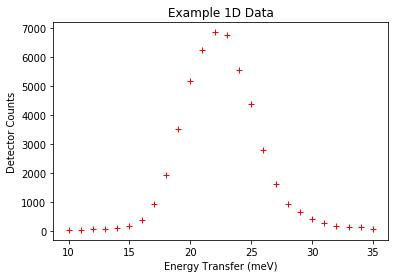

In [23]:
data1D.plot('r+')

### Slicing NXdata Groups
The NXdata groups can be sliced as though they were a Numpy array, since they contain one signal array.

data:NXdata
  @axes = ['yvals', 'xvals']
  @signal = 'zvals'
  title = 'Example 2D Data'
  xvals = float64(51)
  yvals = float64(51)
  zvals = float64(51x51)


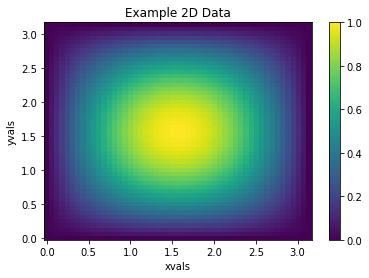

In [24]:
print(data2D[0:51,0:51].tree)
data2D[0:51,0:51].plot()

In an extension of the usual Python slicing syntax, floating point values can be used to extract a slice using the axis values, rather than the signal array indices, to set the limits.

data:NXdata
  @axes = ['yvals', 'xvals']
  @signal = 'zvals'
  title = 'Example 2D Data'
  xvals = float64(51)
  yvals = float64(51)
  zvals = float64(51x51)


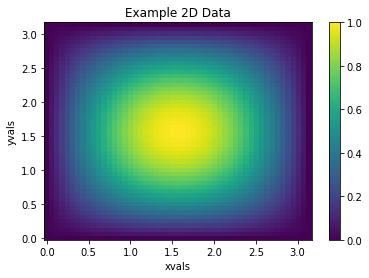

In [25]:
print(data2D[0:np.pi,0:np.pi].tree)
data2D[0:np.pi,0:np.pi].plot()

### Manipulating NXdata Groups
The NXdata groups can be used in arithmetic expressions involving addition, subtraction, multiplication, and division, using the same broadcast rules as Numpy arrays.

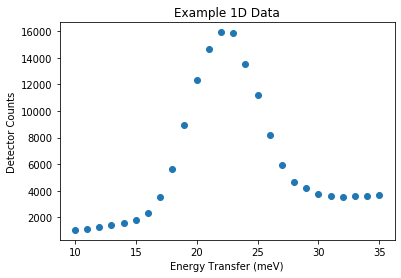

In [26]:
bkgd=100.*data1D.energy_transfer
(2*data1D+bkgd).plot()

Some statistical functions also make use of the information stored within the group. For example, the 

In [27]:
print("Sum: ", str(data1D.sum()), "Average: ", str(data1D.average()), "Moment: ", str(data1D.moment()))

Sum:  49273 Average:  1895.1153846153845 Moment:  22.528768290950417


## NeXus Design
NeXus files should normally follow a standard layout, which is designed to make it easy to understand the contents without any external documentation.

Here is a typical group hierarchy - the NXinstrument groups that are included will depend on the nature of the instrument:

* **NXentry**: This typically encapsulates all the data for a specific run or scan. There can  be multiple NXentry groups, which don't necessarily have to contain the same types of data
  * **NXsample**: Information concerning the measured sample, *e.g.*, temperature or mass
  * **NXinstrument**: The components making up the instrument
    * **NXmonochromator**: The parameters defining a monochromator, such as the incident energy
    * **NXcollimator**: The parameters defining a collimator
    * **NXdetector**: The parameters defining the detector(s)
  * **NXdata**: The measured data

This can be easily initialized by the `nexusformat` package. If the default names are acceptable, then just type the following:

In [28]:
root=NXroot(NXentry(sample,NXinstrument(NXmonochromator(),NXcollimator(),NXdetector()),data1D))
print(root.tree)

root:NXroot
  entry:NXentry
    data:NXdata
      @axes = 'energy_transfer'
      @signal = 'counts'
      counts = int16(26)
        @long_name = 'Detector Counts'
      energy_transfer = float32(26)
        @long_name = 'Energy Transfer (meV)'
        @units = 'meV'
      title = 'Example 1D Data'
    instrument:NXinstrument
      collimator:NXcollimator
      detector:NXdetector
      monochromator:NXmonochromator
    sample:NXsample


> The `NXroot` is a virtual class that defines the file-level of a NeXus tree.

Metadata can then be added to the created groups.

Once a root group has been defined, it can be saved to a file.
## Saving and Loading NeXus Data
So far, we have created a NeXus file purely in memory, but it can be saved to disk at any time. Afterwards, all subsequent operations on the data will be automatically saved to the file.

In [29]:
print(root.tree)
root.save('example.nxs','w')

root:NXroot
  entry:NXentry
    data:NXdata
      @axes = 'energy_transfer'
      @signal = 'counts'
      counts = int16(26)
        @long_name = 'Detector Counts'
      energy_transfer = float32(26)
        @long_name = 'Energy Transfer (meV)'
        @units = 'meV'
      title = 'Example 1D Data'
    instrument:NXinstrument
      collimator:NXcollimator
      detector:NXdetector
      monochromator:NXmonochromator
    sample:NXsample


NXroot('root')

This data can be reloaded using the `nxload` function. Possible file modes are:
* `r`: Open as read-only
* `rw`: Open as read-write

In [30]:
saved_file=nxload('example.nxs','rw')
print(saved_file.tree)

root:NXroot
  @HDF5_Version = '1.10.4'
  @file_name = '/Users/rosborn/Documents/Computing/Repositorie...'
  @file_time = '2019-08-05T15:30:50.448401'
  @h5py_version = '2.9.0'
  @nexusformat_version = '0.4.20'
  entry:NXentry
    data:NXdata
      @axes = 'energy_transfer'
      @signal = 'counts'
      counts = int16(26)
        @long_name = 'Detector Counts'
      energy_transfer = float32(26)
        @long_name = 'Energy Transfer (meV)'
        @units = 'meV'
      title = 'Example 1D Data'
    instrument:NXinstrument
      collimator:NXcollimator
      detector:NXdetector
      monochromator:NXmonochromator
    sample:NXsample


If the file is opened in read-write mode, all changes to the file are saved automatically.

In [31]:
saved_file['entry/instrument/monochromator/energy']=NXfield(120.0, units='meV')
print(saved_file.tree)

root:NXroot
  @HDF5_Version = '1.10.4'
  @file_name = '/Users/rosborn/Documents/Computing/Repositorie...'
  @file_time = '2019-08-05T15:30:50.448401'
  @h5py_version = '2.9.0'
  @nexusformat_version = '0.4.20'
  entry:NXentry
    data:NXdata
      @axes = 'energy_transfer'
      @signal = 'counts'
      counts = int16(26)
        @long_name = 'Detector Counts'
      energy_transfer = float32(26)
        @long_name = 'Energy Transfer (meV)'
        @units = 'meV'
      title = 'Example 1D Data'
    instrument:NXinstrument
      collimator:NXcollimator
      detector:NXdetector
      monochromator:NXmonochromator
        energy = 120.0
          @units = 'meV'
    sample:NXsample


NeXus files can be backed up if required.

In [32]:
saved_file.backup()
saved_file['entry/instrument/monochromator/energy']=NXfield(160.0, units='meV')
print(saved_file.nxbackup)
saved_file.restore(overwrite=True)
print(saved_file.tree)

NeXusError: The value is incompatible with the shape